          Date       Open       High        Low      Close  Adj Close  \
5   2004-08-26  52.279045  53.773445  52.134586  53.753517  53.753517   
11  2004-09-03  50.286514  50.680038  49.474556  49.818268  49.818268   
17  2004-09-14  53.524376  55.790882  53.195610  55.536835  55.536835   
23  2004-09-22  58.480801  59.611561  58.186901  58.968971  58.968971   
29  2004-09-30  64.707458  65.902977  64.259140  64.558022  64.558022   

      Volume  
5    7128600  
11   5176800  
17  10880300  
23   7617100  
29  13823300  


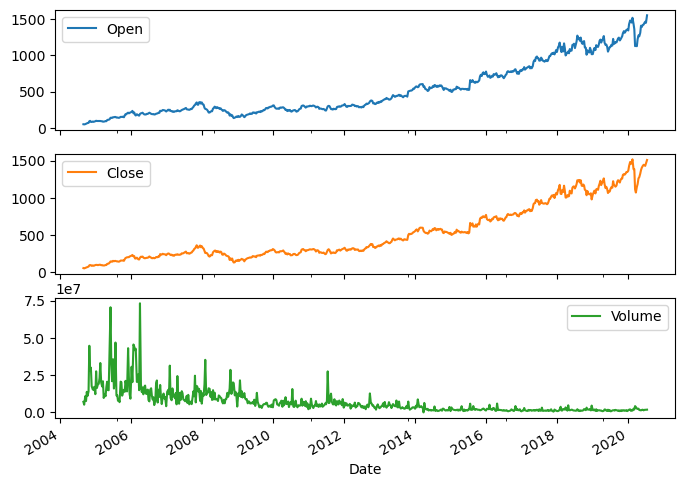

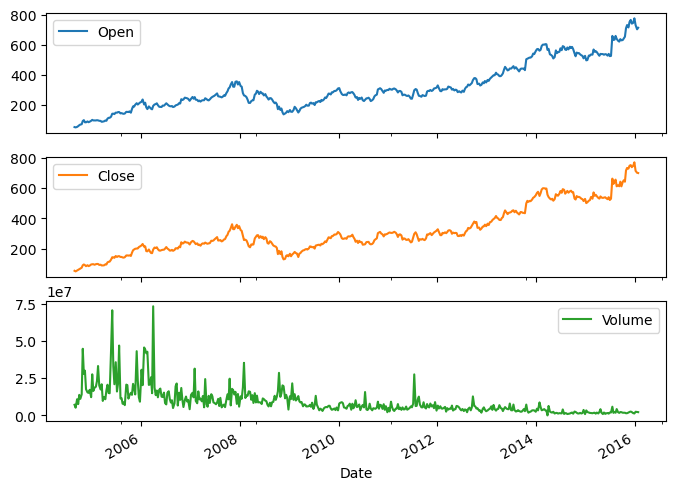

In [1]:
import os
import datetime
import IPython
import IPython.display

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Чтение файла
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
df = pd.read_csv("GOOG.csv", delimiter=",")
df = df[5::6]
print(df.head())
date_time = pd.to_datetime(df.pop('Date'), format='%Y.%m.%d')
plot_cols = ['Open', 'Close', 'Volume']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)
plt.show()

In [2]:
# Разделение на выборки
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

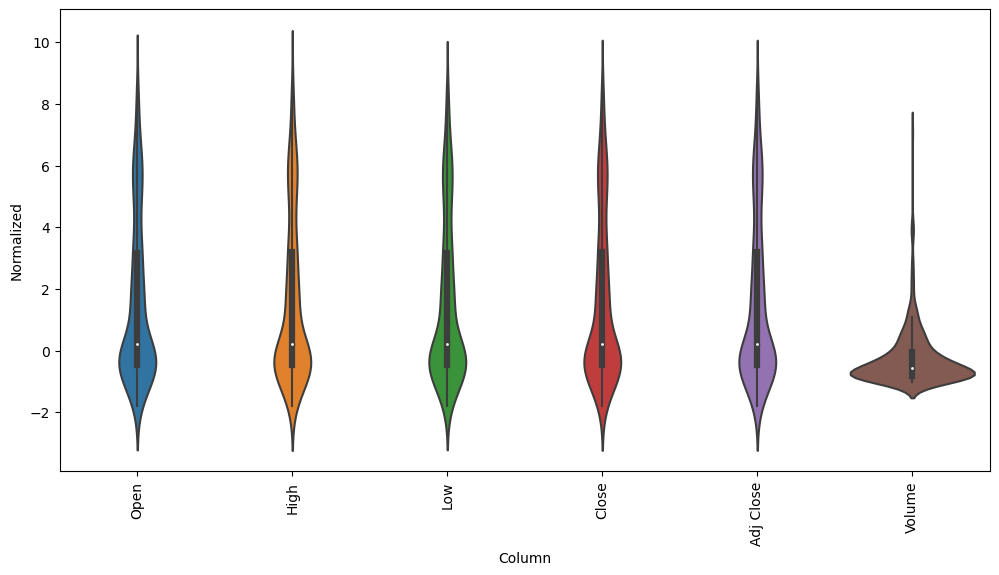

In [3]:
# Нормализация данных
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Open']
Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Open']
All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
Labels shape: (3, 1, 1)


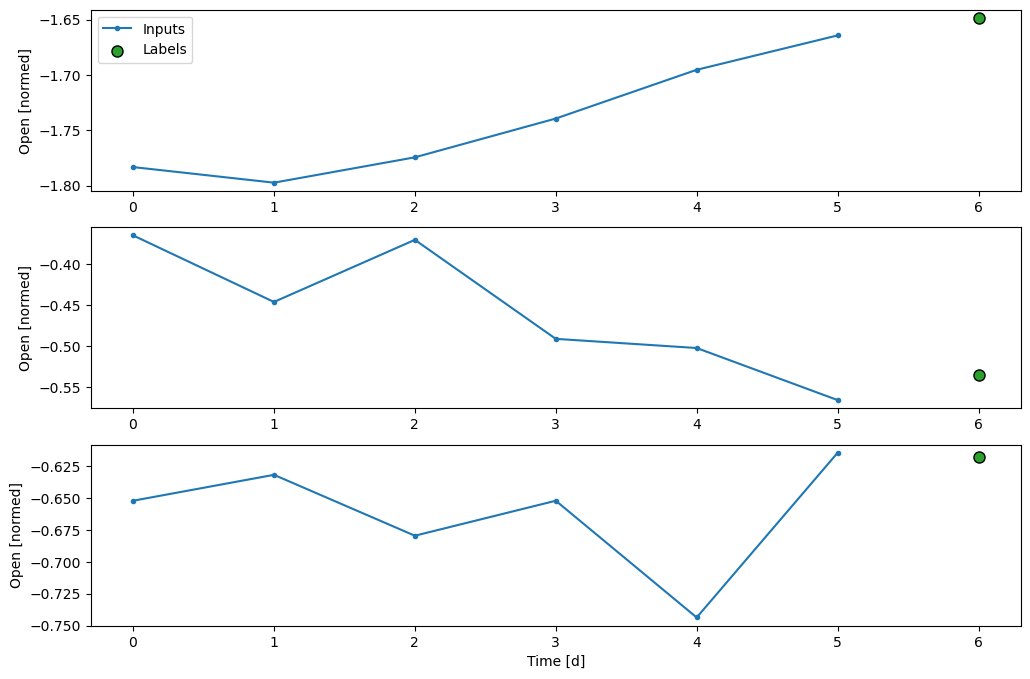

In [4]:
# Окно данных
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                                        enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])


w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                    label_columns=['Open'])
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                    label_columns=['Open'])
print(w1)
print(w2)


def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels


WindowGenerator.split_window = split_window
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                            np.array(train_df[100:100+w2.total_window_size]),
                            np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

w2.example = example_inputs, example_labels


def plot(self, model=None, plot_col='Open', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [d]')


WindowGenerator.plot = plot
w2.plot()
plt.show()

In [5]:
# Создаем датасет
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)
    return ds


WindowGenerator.make_dataset = make_dataset


@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def val(self):
    return self.make_dataset(self.val_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
print(w2.train.element_spec)
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

(TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (32, 6, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [6]:
# Одношаговые модели
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Open'])
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


5/5 [==============================] - 0s 1ms/step - loss: 0.0607 - mean_absolute_error: 0.1874
Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


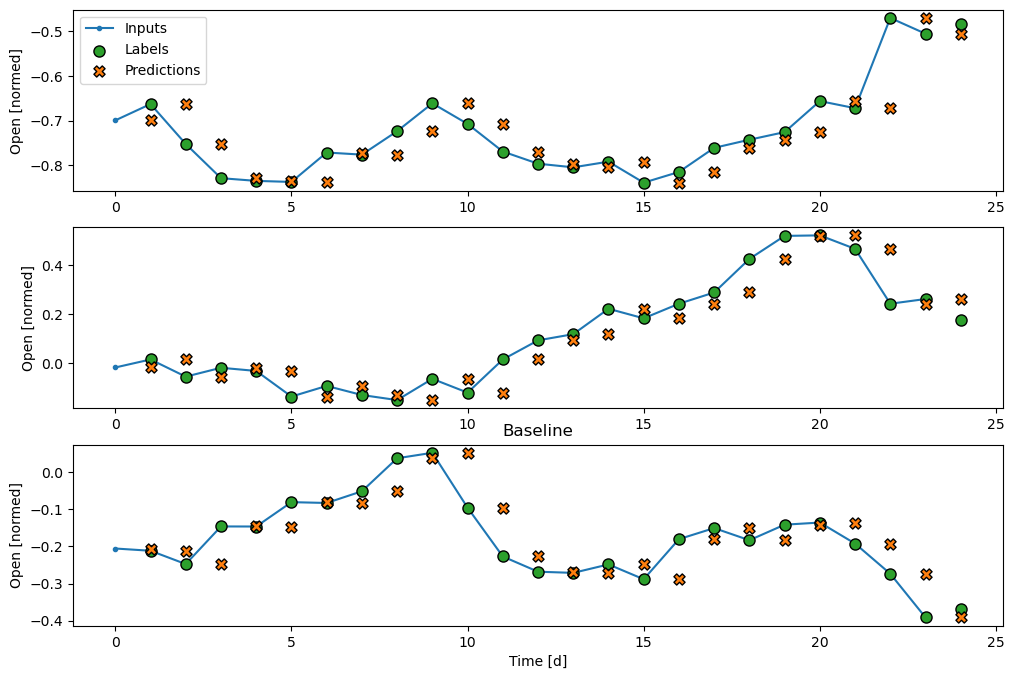

In [7]:
# Базовый уровень
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


baseline = Baseline(label_index=column_indices['Open'])

baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Open'])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
wide_window.plot(baseline)
plt.title("Baseline")
plt.show()

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)
Epoch 1/40
15/15 [==============================] - 1s 10ms/step - loss: 0.9426 - mean_absolute_error: 0.7283 - val_loss: 8.5698 - val_mean_absolute_error: 2.8299
Epoch 2/40
15/15 [==============================] - 0s 4ms/step - loss: 0.8013 - mean_absolute_error: 0.6694 - val_loss: 6.7660 - val_mean_absolute_error: 2.5137
Epoch 3/40
15/15 [==============================] - 0s 5ms/step - loss: 0.6785 - mean_absolute_error: 0.6119 - val_loss: 5.2468 - val_mean_absolute_error: 2.2126
Epoch 4/40
15/15 [==============================] - 0s 6ms/step - loss: 0.5708 - mean_absolute_error: 0.5582 - val_loss: 4.0092 - val_mean_absolute_error: 1.9329
Epoch 5/40
15/15 [==============================] - 0s 3ms/step - loss: 0.4796 - mean_absolute_error: 0.5081 - val_loss: 2.9878 - val_mean_absolute_error: 1.6666
Epoch 6/40
15/15 [==============================] - 0s 4ms/step - loss: 0.4022 - mean_absolute_error: 0.4612 - val_loss: 2.1478 - val_mean_a

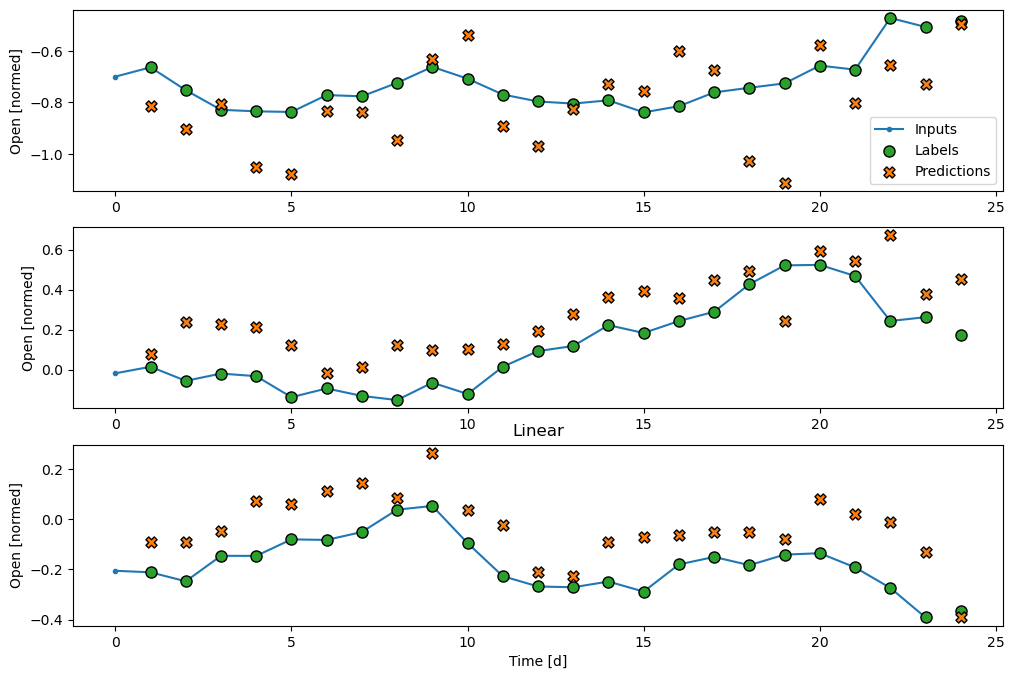

In [8]:
# Линейная модель
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)
MAX_EPOCHS = 40


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history


history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

wide_window.plot(linear)
plt.title("Linear")
plt.show()

Epoch 1/40
15/15 [==============================] - 1s 15ms/step - loss: 0.3771 - mean_absolute_error: 0.4225 - val_loss: 0.0718 - val_mean_absolute_error: 0.2008
Epoch 2/40
15/15 [==============================] - 0s 4ms/step - loss: 0.0345 - mean_absolute_error: 0.1476 - val_loss: 0.0559 - val_mean_absolute_error: 0.1734
Epoch 3/40
15/15 [==============================] - 0s 7ms/step - loss: 0.0144 - mean_absolute_error: 0.0865 - val_loss: 0.2056 - val_mean_absolute_error: 0.3842
Epoch 4/40
5/5 [==============================] - 0s 997us/step - loss: 0.0600 - mean_absolute_error: 0.1856


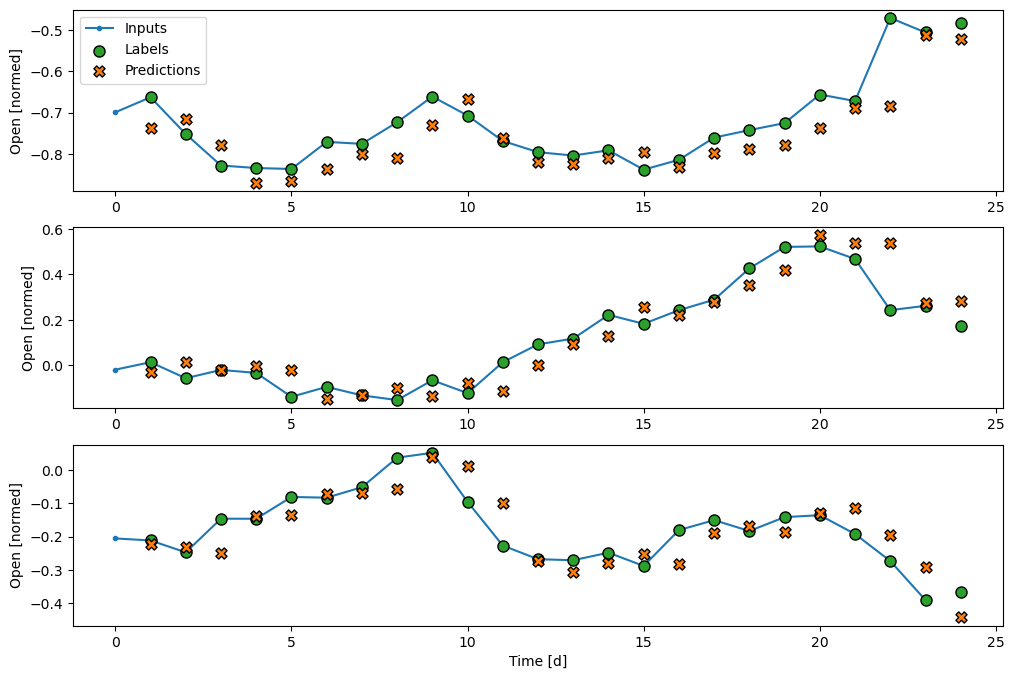

In [9]:
# Плотная модель
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
wide_window.plot(dense)

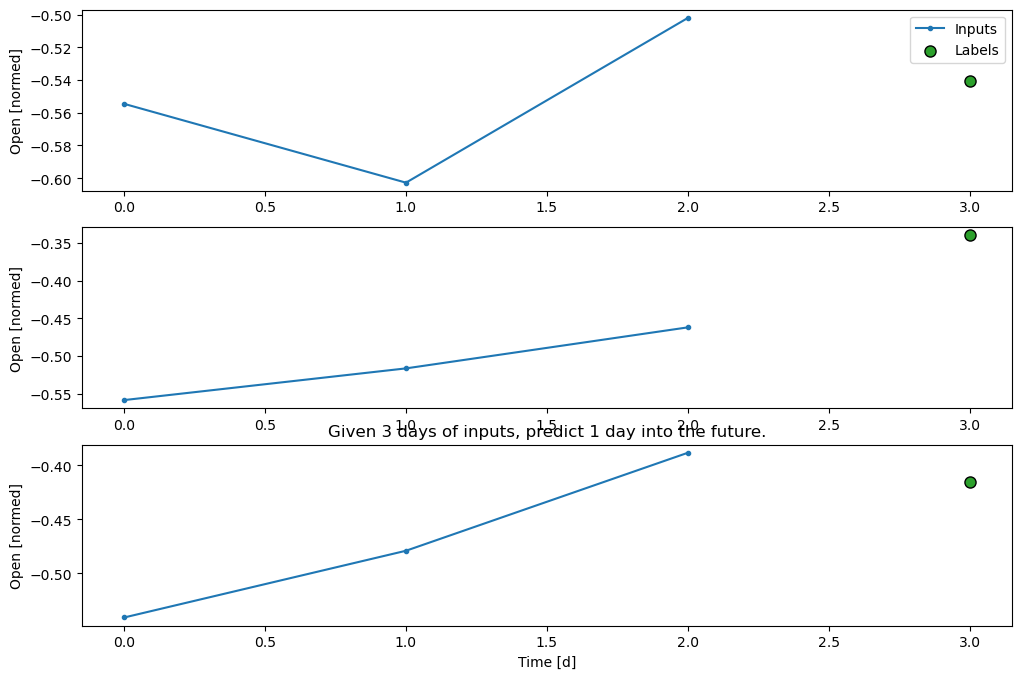

In [10]:
# Многоступенчатая плотная модель
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Open'])
conv_window.plot()
plt.title("Given 3 days of inputs, predict 1 day into the future.")
plt.show()

5/5 [==============================] - 0s 1ms/step - loss: 0.0588 - mean_absolute_error: 0.1771


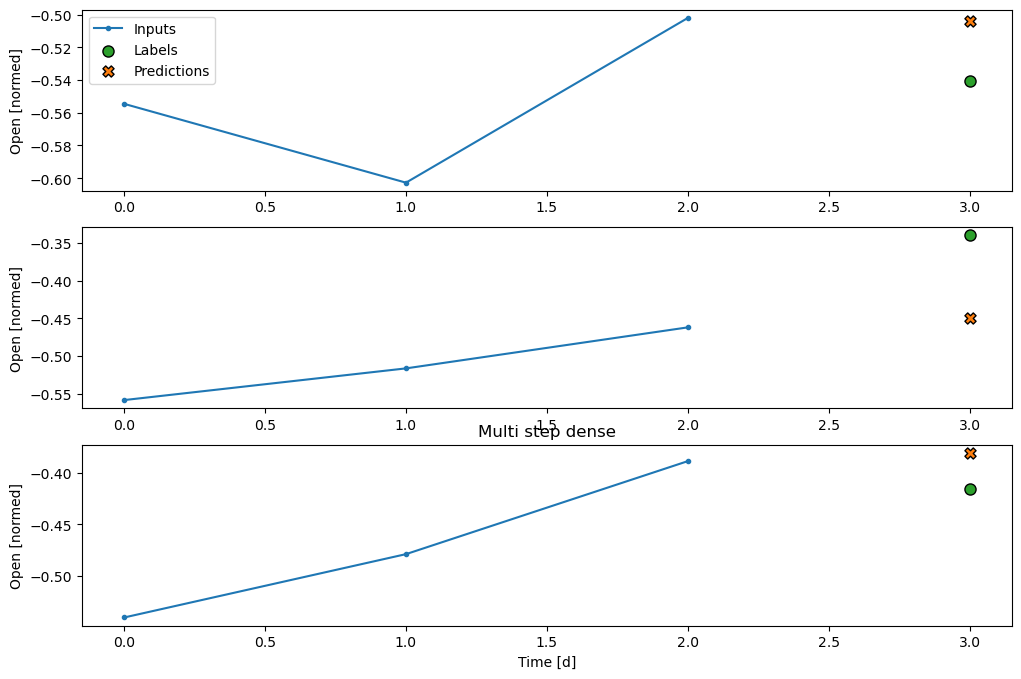

In [11]:
# Многоступенчатая плотная модель
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]),
])
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)
conv_window.plot(multi_step_dense)
plt.title("Multi step dense")
plt.show()

5/5 [==============================] - 0s 748us/step - loss: 0.1764 - mean_absolute_error: 0.3425
Wide window
Input shape: (32, 24, 6)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)
Wide conv window
Input shape: (32, 26, 6)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


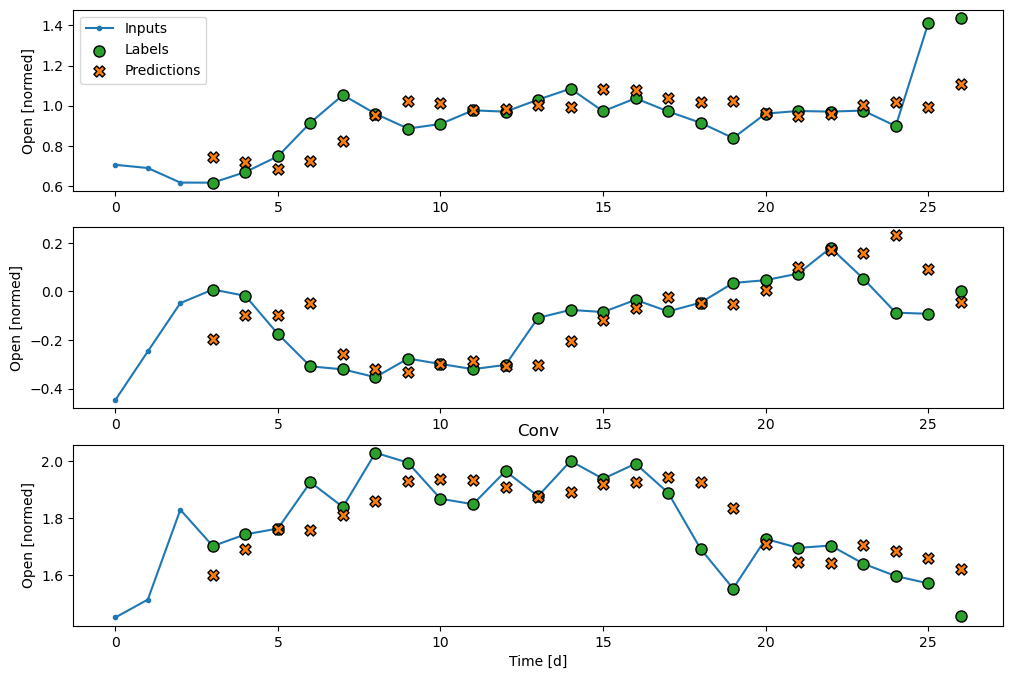

In [12]:
# Сверточная
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Open'])

print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)
wide_conv_window.plot(conv_model)
plt.title("Conv")
plt.show()

4/4 [==============================] - 0s 3ms/step - loss: 1.7719 - mean_absolute_error: 1.0814


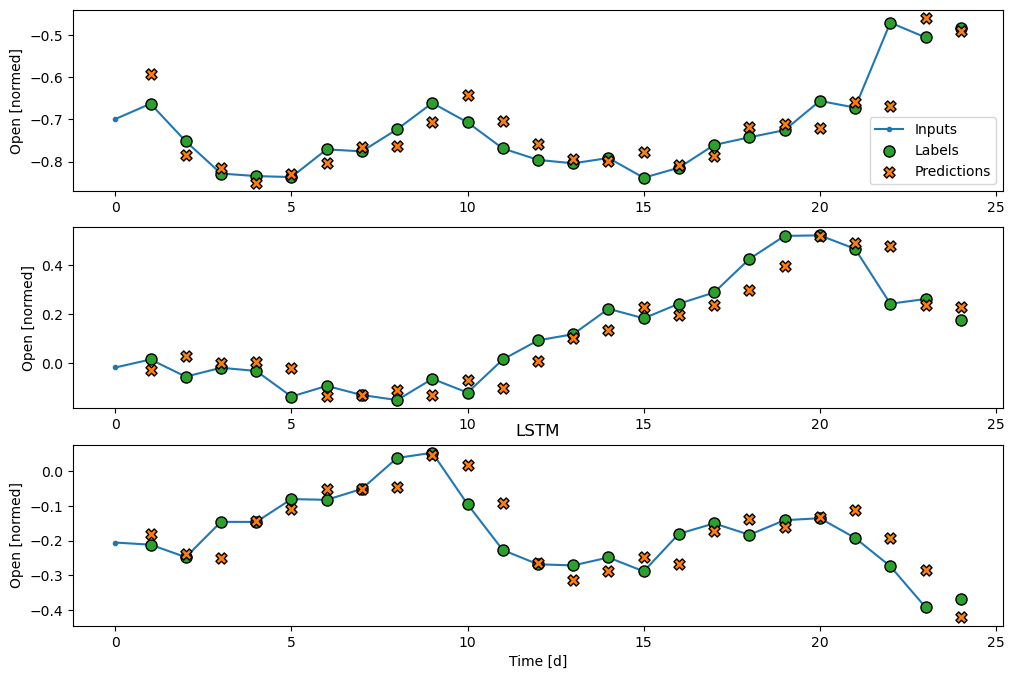

In [13]:
# Реккурентная
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(lstm_model)
plt.title("LSTM")
plt.show()

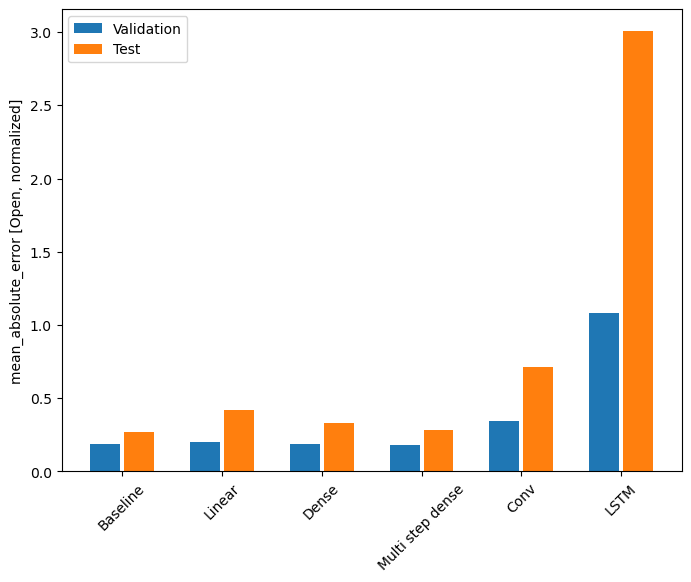

Baseline    : 0.2659
Linear      : 0.4203
Dense       : 0.3310
Multi step dense: 0.2816
Conv        : 0.7114
LSTM        : 3.0046


In [14]:
# Представление
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Open, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()
plt.show()
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

In [15]:
# Модели с несколькими выходами
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 6)
Labels shape (batch, time, features): (32, 24, 6)


In [16]:
# Базовая
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

4/4 [==============================] - 0s 1ms/step - loss: 0.0449 - mean_absolute_error: 0.1512


In [17]:
# Плотная
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

5/5 [==============================] - 0s 998us/step - loss: 0.1908 - mean_absolute_error: 0.3397


In [18]:
# РНН
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

4/4 [==============================] - 0s 3ms/step - loss: 2.4219 - mean_absolute_error: 1.2318



In [19]:
# Остаточные соединения
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
        return inputs + delta
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

4/4 [==============================] - 0s 3ms/step - loss: 0.0453 - mean_absolute_error: 0.1526



Baseline       : 0.2156
Dense          : 0.6981
LSTM           : 2.9427
Residual LSTM  : 0.2207


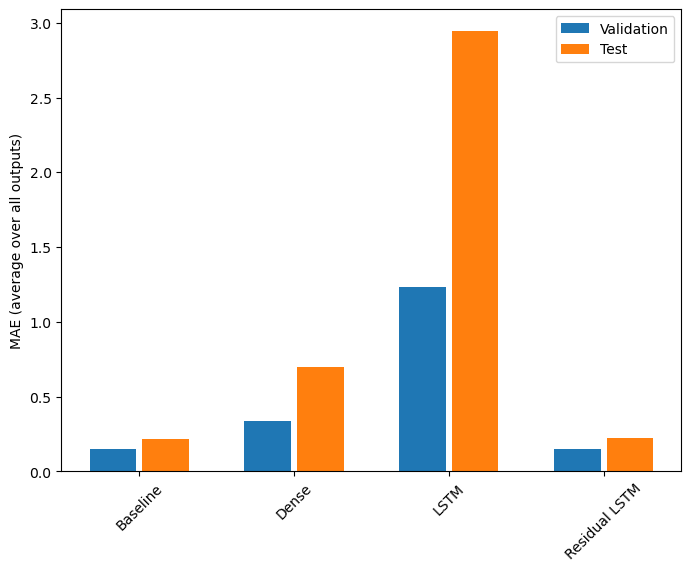

In [20]:
# Представление
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')

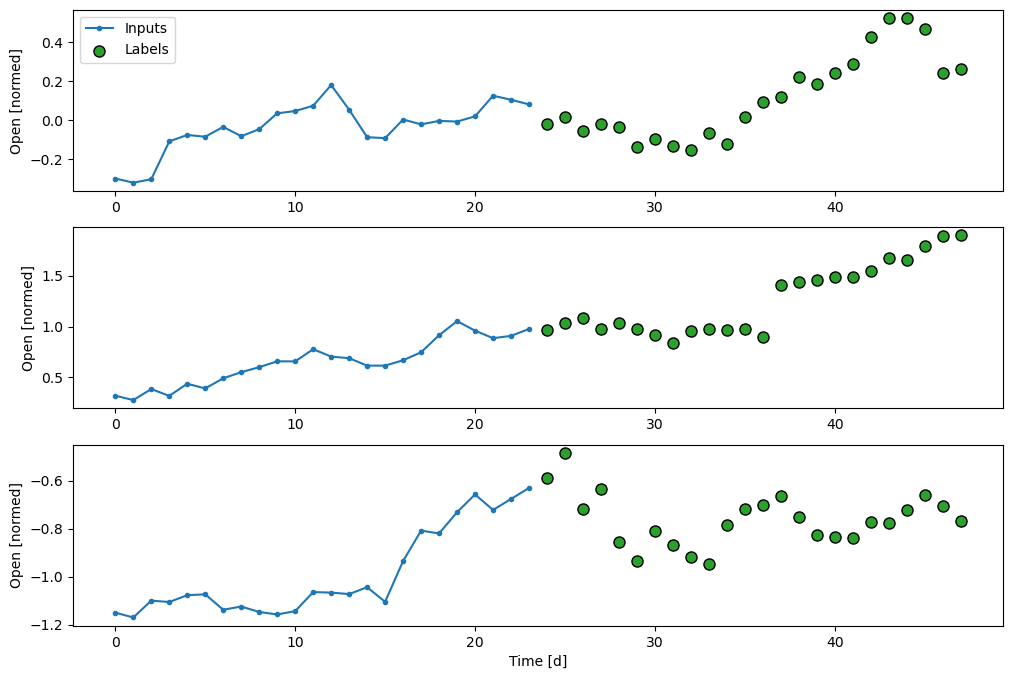

In [21]:
# Многошаговые модели
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS, label_columns=['Open'])

multi_window.plot()
plt.show()


multi_val_performance = {}
multi_performance = {}

3/3 [==============================] - 0s 2ms/step - loss: 5.4222 - mean_absolute_error: 1.3243


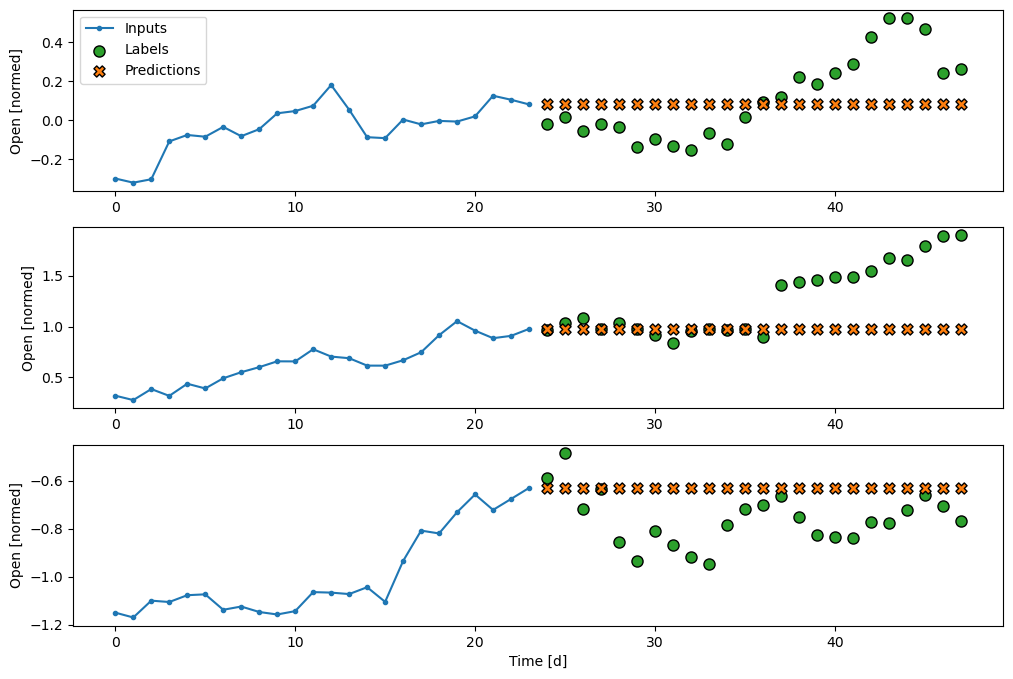

In [22]:
# Базовый уровень(Линия)
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

3/3 [==============================] - 0s 982us/step - loss: 5.6800 - mean_absolute_error: 1.5325


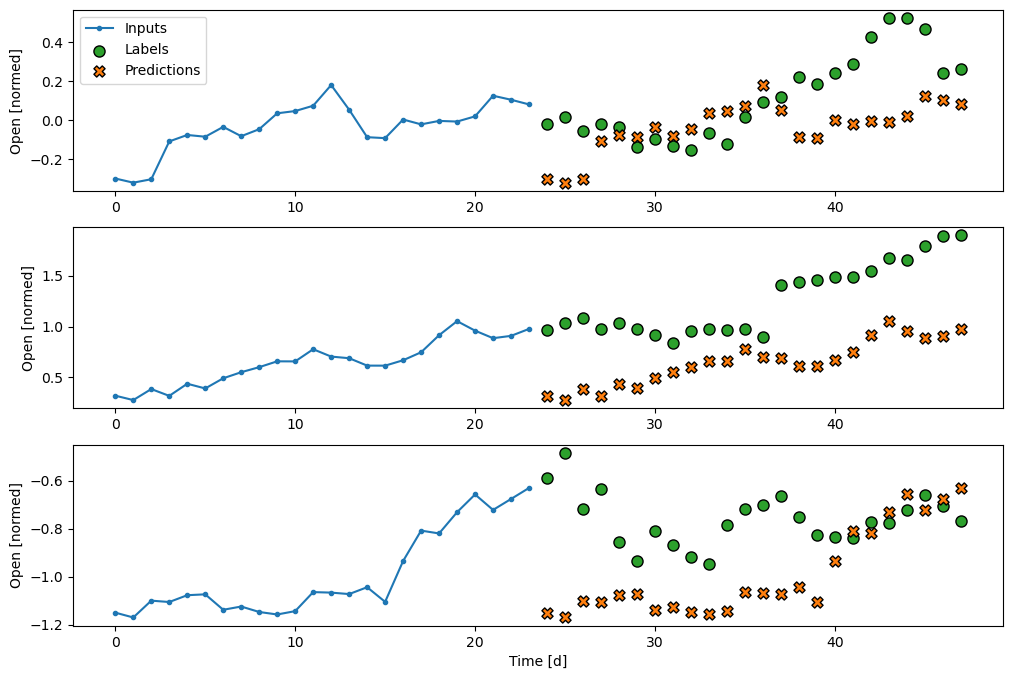

In [23]:
#Однократные
#Базовый уровень(Повторение)
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

3/3 [==============================] - 0s 1ms/step - loss: 0.6802 - mean_absolute_error: 0.6898


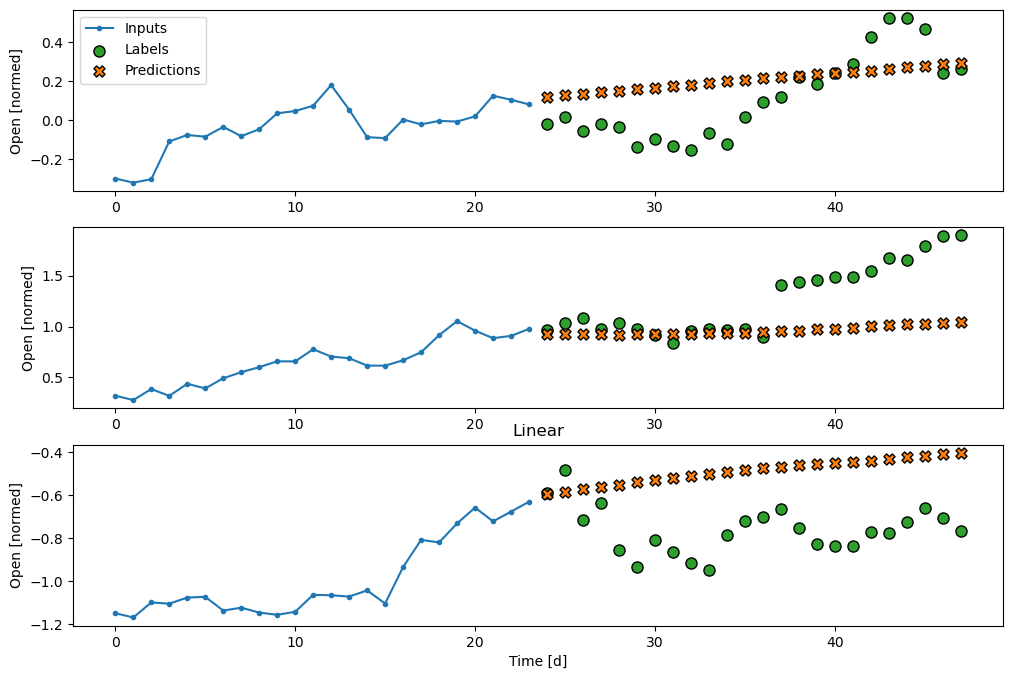

In [24]:
# Линейная модель
multi_linear_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)
plt.title("Linear")
plt.show()

3/3 [==============================] - 0s 1ms/step - loss: 0.5152 - mean_absolute_error: 0.5914


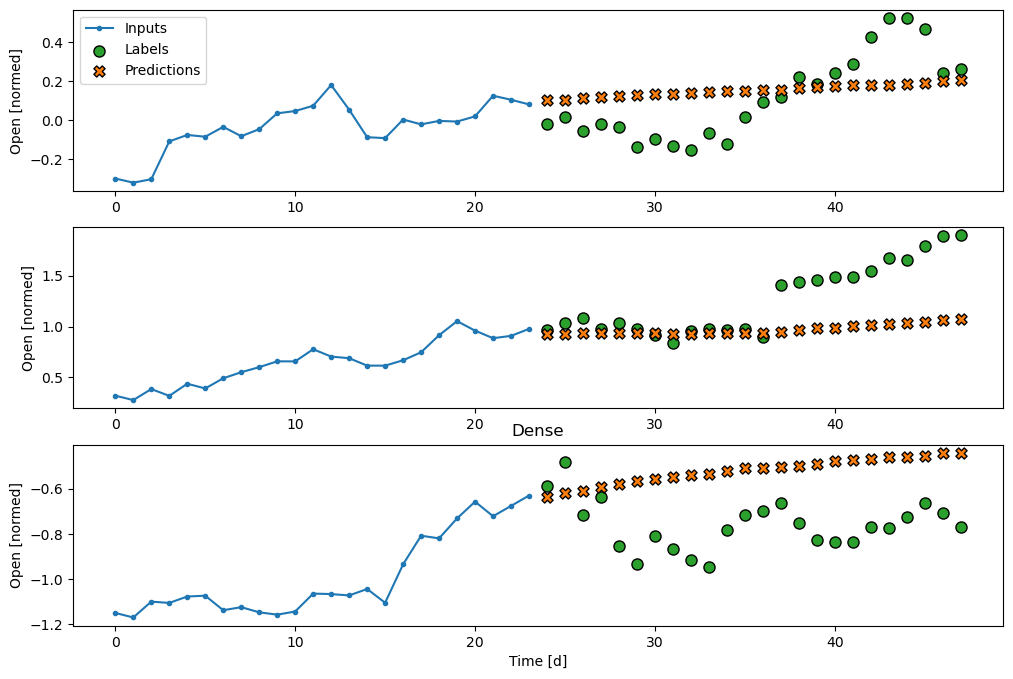

In [25]:
# Полносвязная модель
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)
plt.title("Dense")
plt.show()

3/3 [==============================] - 0s 997us/step - loss: 0.3812 - mean_absolute_error: 0.4872


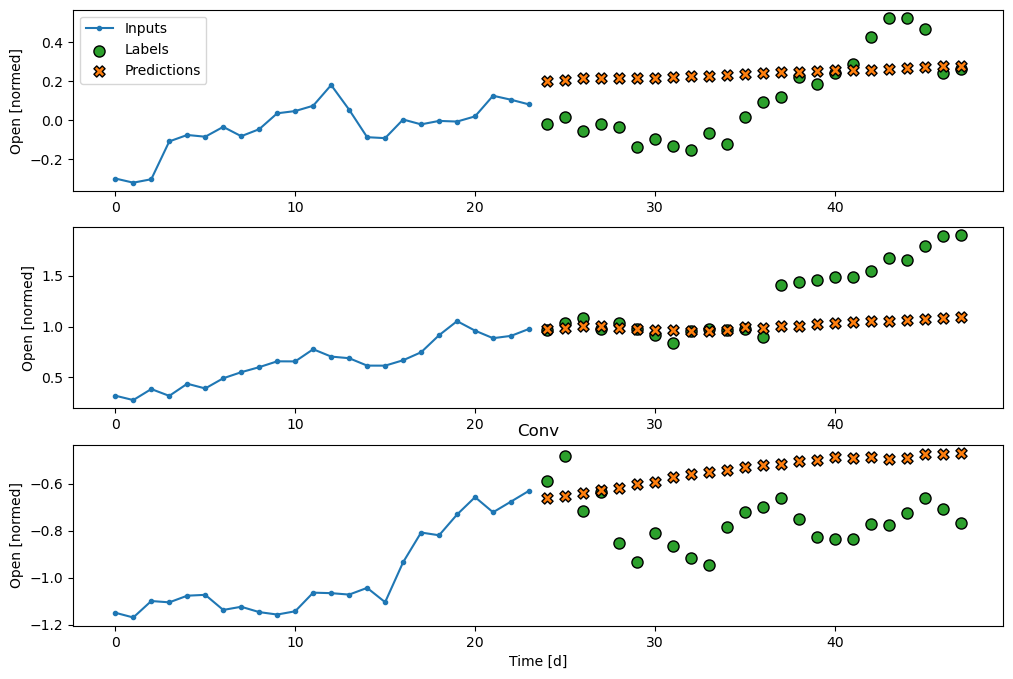

In [26]:
# Сверточная
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)
plt.title("Conv")
plt.show()

3/3 [==============================] - 0s 3ms/step - loss: 8.8306 - mean_absolute_error: 2.8008


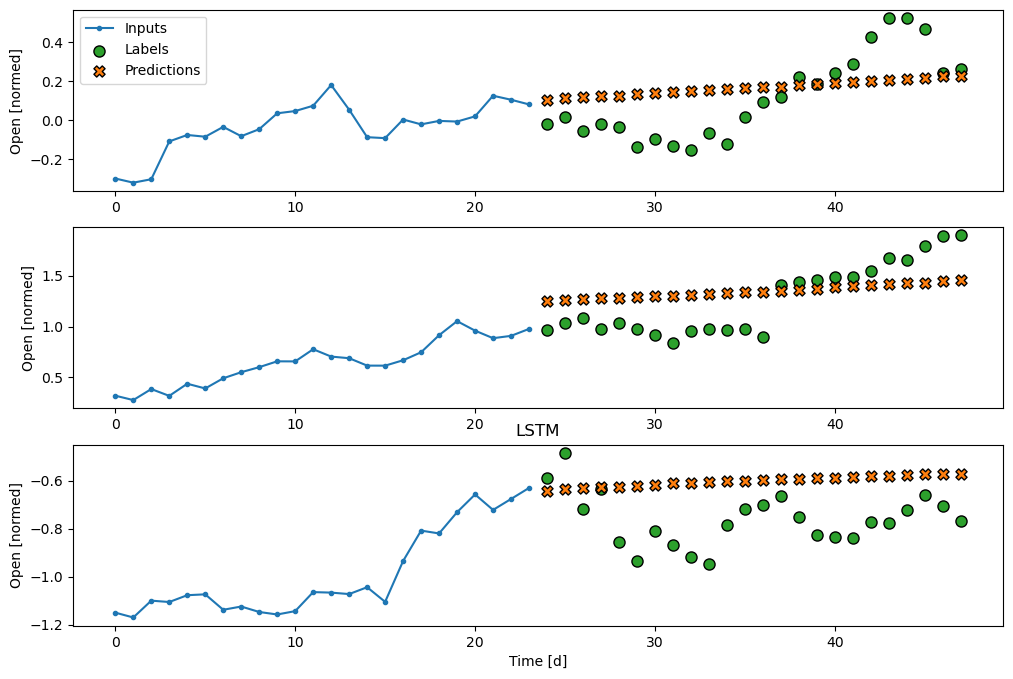

In [27]:
# Реккурентная
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)
plt.title("LSTM")
plt.show()

3/3 [==============================] - 0s 5ms/step - loss: 8.6106 - mean_absolute_error: 2.7601


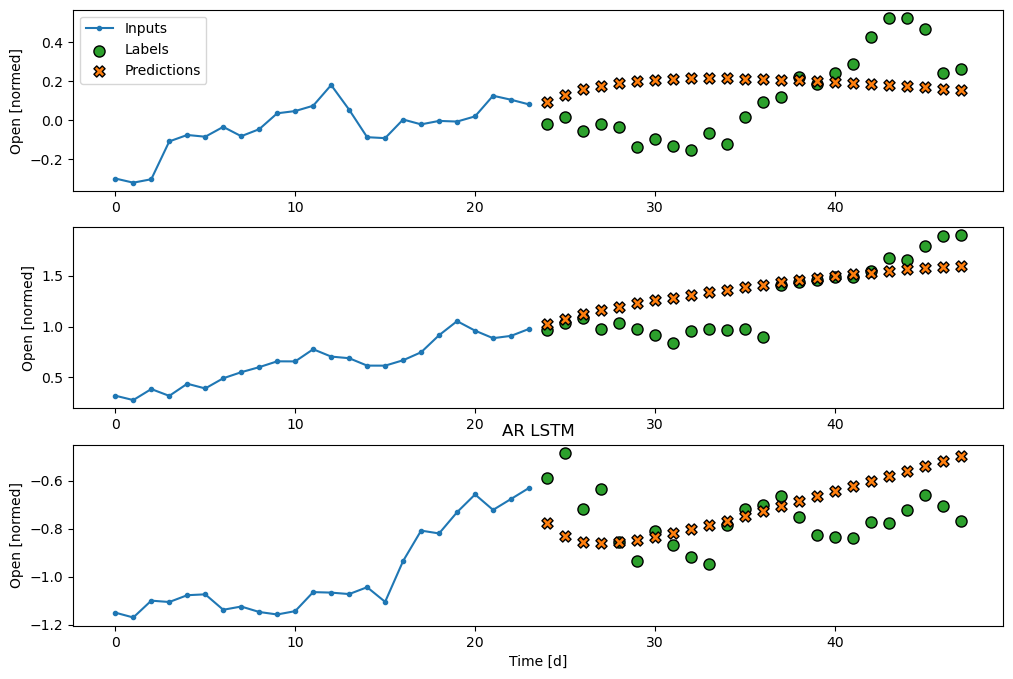

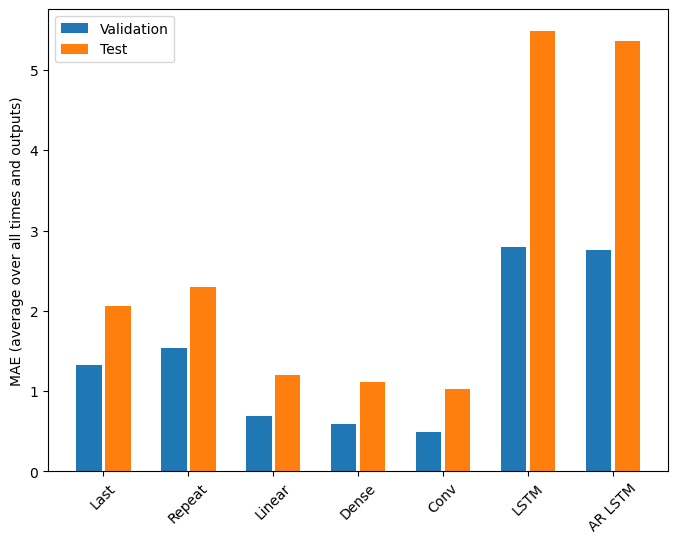

Last    : 2.0637
Repeat  : 2.2975
Linear  : 1.2029
Dense   : 1.1190
Conv    : 1.0240
LSTM    : 5.4815
AR LSTM : 5.3598


In [28]:
# Авторегрессионная модель
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)


feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)


def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)
    prediction = self.dense(x)
    return prediction, state


FeedBack.warmup = warmup
prediction, state = feedback_model.warmup(multi_window.example[0])


def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state, training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


FeedBack.call = call
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)
plt.title("AR LSTM")
plt.show()
# Представление
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()
plt.show()
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')